# **(ADD THE NOTEBOOK NAME HERE)**

## Objectives

* Write your notebook objective here, for example, "Fetch data from Kaggle and save as raw data", or "engineer features for modelling"

## Inputs

* Write down which data or information you need to run the notebook 

## Outputs

* Write here which files, code or artefacts you generate by the end of the notebook 

## Additional Comments

* If you have any additional comments that don't fit in the previous bullets, please state them here. 



---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [ ]:
import os
current_dir = os.getcwd()
current_dir

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [ ]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

Confirm the new current directory

In [ ]:
current_dir = os.getcwd()
current_dir

**Import Libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


**Load Dataset and test it**

In [ ]:
raw_path = "Data\Raw\global-data-on-sustainable-energy.csv"
df = pd.read_csv(raw_path, encoding='latin1')
df.head()

***ETL***

**Rename the colums for easier access**

In [ ]:
df.rename(columns={
    'Entity': 'country',
    'Access to electricity (% of population)': 'access_to_electricity',
    'Access to clean fuels for cooking': 'access_to_clean_fuels',
    'Renewable-electricity-generating-capacity-per-capita': 'renewable_capacity_per_capita',
    'Financial flows to developing countries (US $)': 'financial_flows',
    'Renewable energy share in the total final energy consumption (%)': 'renewable_energy_share',
    'Electricity from fossil fuels (TWh)': 'fossil_electricity',
    'Electricity from nuclear (TWh)': 'nuclear_electricity',
    'Electricity from renewables (TWh)': 'renewable_electricity',
    'Low-carbon electricity (% electricity)': 'low_carbon_electricity_pct',
    'Primary energy consumption per capita (kWh/person)': 'primary_energy_per_capita',
    'Energy intensity level of primary energy (MJ/$2017 PPP GDP)': 'energy_intensity',
    'Value_co2_emissions_kt_by_country': 'co2_emissions_kt',
    'density\\np/km2': 'density'
}, inplace=True)
# Cleaning column names
df.columns = df.columns.str.strip().str.lower().str.replace('\n', '_').str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
df.rename(columns={
    'density\\np/km2': 'density'
}, inplace=True)
df.head()

**Check types**

In [ ]:
df.dtypes

**Check Null values**

In [ ]:
null_columns = df.isnull().sum()
null_columns = null_columns[null_columns > 0]
print(null_columns)


**Eliminate columns with too many null values and redundant data**

In [ ]:
columns_to_drop = ['density', 'land_areakm2', 'latitude', 'longitude', 'renewables_%_equivalent_primary_energy', 'financial_flows']
df.drop(columns=columns_to_drop, inplace=True)
print("Dropped columns:", columns_to_drop)

In [ ]:
null_columns = df.isnull().sum()
print(null_columns)

**Use interpolate to fill the null values**

In [ ]:
df.interpolate(method='linear', inplace=True)
df = df.sort_values(by=['country', 'year'])
df = df.groupby('country').apply(lambda group: group.interpolate(method='linear', limit_direction='both'))
null_columns = df.isnull().sum()
print(null_columns)

**Save the dataset as a clean csv**

In [ ]:
processed_path = "Data/Processed/global-data-on-sustainable-energy-processed.csv"
df.to_csv(processed_path, index=False)
print("Processed data saved to:", processed_path)

In [ ]:
processed_df = pd.read_csv(processed_path)
print("Processed data loaded successfully.")
processed_df.head()

# EDA

Visual check

In [58]:
processed_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3649 entries, 0 to 3648
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   country                        3649 non-null   object 
 1   year                           3649 non-null   int64  
 2   access_to_electricity          3649 non-null   float64
 3   access_to_clean_fuels          3649 non-null   float64
 4   renewable_capacity_per_capita  3649 non-null   float64
 5   renewable_energy_share         3649 non-null   float64
 6   fossil_electricity             3649 non-null   float64
 7   nuclear_electricity            3649 non-null   float64
 8   renewable_electricity          3649 non-null   float64
 9   low_carbon_electricity_pct     3649 non-null   float64
 10  primary_energy_per_capita      3649 non-null   float64
 11  energy_intensity               3649 non-null   float64
 12  co2_emissions_kt               3649 non-null   f

Basic statistics

In [ ]:
processed_df.describe().T

### 1. Global Trend in Access to Electricity

This plot shows the average global access to electricity from 2000 to 2020. The trend is upward, which reflects the overall global effort toward achieving SDG 7 targets.


In [ ]:
global_access = processed_df.groupby('year')['access_to_electricity'].mean().reset_index()

plt.plot(global_access['year'], global_access['access_to_electricity'], marker='o')
plt.title('Global Access to Electricity Over Time')
plt.xlabel('Year')
plt.ylabel('Access to Electricity (% of Population)')
plt.grid()
plt.show()

We can observe a steady global improvement, from approximately 73% in 2000 to over 85% by 2020. However, this global average may hide severe disparities among regions and countries.


### 2. Countries with the Lowest Electricity Access in 2020

This horizontal bar chart displays the bottom 10 countries in terms of electricity access percentage. All values are below 30%, highlighting critical energy poverty.


In [ ]:
latest_year = processed_df['year'].max()
bottom_10_countries = processed_df[processed_df['year'] == latest_year].nsmallest(10, 'access_to_electricity')

sns.barplot(data=bottom_10_countries, x='access_to_electricity', y='country', palette='viridis')
plt.title(f'Bottom 10 Countries by Access to Electricity in {latest_year}')
plt.xlabel('Access to Electricity (% of Population)')
plt.ylabel('Country')
plt.show()

South Sudan, Chad, and Burundi have the lowest access rates, many below 10%. These countries are in Sub-Saharan Africa, where infrastructure and political instability are major limiting factors.


### 3. Correlation Between Key Energy and Development Indicators

This correlation matrix helps us understand the relationships between electricity access, clean fuels, renewables, energy intensity, emissions, and GDP per capita.

In [ ]:
correlation_cols = ['access_to_electricity', 'access_to_clean_fuels', 'renewable_capacity_per_capita',
                    'renewable_energy_share', 'fossil_electricity', 'nuclear_electricity',
                    'energy_intensity', 'co2_emissions_kt', 'gdp_per_capita']

correlation_matrix = processed_df[correlation_cols].corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Correlation Matrix of Key Variables')
plt.show()

There is a strong positive correlation between access to electricity and clean fuels (0.84), as expected. Interestingly, renewable energy share has a strong **negative correlation** with access indicators, which may suggest that countries with high renewables still struggle with universal access — potentially due to underdeveloped grids. GDP per capita shows a moderate positive correlation with electricity access (0.41).


---

### 4. Choropleth Map: Access to Electricity by Country (2020)

This interactive choropleth map displays global disparities in access to electricity. Each country is shaded according to the percentage of its population with access to electricity in the year 2020.

The map helps identify geographic patterns of energy inequality. Sub-Saharan Africa shows notably lower access levels, while most developed regions are above 95%.


In [ ]:
# filter by year

for year in [2000, 2010, 2020]:
    df_year = df[df["year"] == year]
    fig = px.choropleth(
        df_year,
        locations="country",
        locationmode="country names",
        color="access_to_electricity",
        hover_name="country",
        color_continuous_scale="YlGnBu",
        title=f"Global Electricity Access – {year}",
        labels={'access_to_electricity': '% Electricity Access'}
    )
    fig.show()

fig.update_layout(
    geo=dict(showframe=False, showcoastlines=True, coastlinecolor='Black'),
    margin=dict(l=0, r=0, t=50, b=0),
    coloraxis_colorbar=dict(title='Access to Electricity (%)') )

The visualization confirms the critical need for investment in electricity infrastructure across many African countries. This spatial insight supports the focus of SDG 7 on closing energy access gaps globally. The countries that did not appear on the map are missing due to the absence of data.



# Hypothesis

### GDP per Capita vs Access to clean Energy

countries with lower GDP per capita tend to have lower access to clean energy
- Access to electriciy
- access to clean fuels for cooking

this will be analysed using scatter plots and correlation coefficients.


In [ ]:
# Filter by year
latest_year = processed_df['year'].max()


# Scatter plot: GDP per capita vs Access to Electricity
sns.scatterplot(
    data=df_year,
    x='gdp_per_capita',
    y='access_to_electricity'
)
plt.title('GDP per Capita vs Access to Electricity (2020)')
plt.xlabel('GDP per Capita (USD)')
plt.ylabel('Access to Electricity (%)')
plt.grid(True)
plt.show()

In [ ]:
# Filter by year
year = 2020
df_year = df[df["year"] == year]

# 5 countries with lowest access to electricity
bottom5 = df_year.sort_values("access_to_electricity").head(5)["country"].unique()

# Filter the DataFrame for the bottom 5 countries
df_violin = df[df["country"].isin(bottom5)]

# Create a violin plot for GDP per capita in the bottom 5 countries
plt.figure(figsize=(10, 6))
sns.violinplot(
    data=df_violin,
    x="country",
    y="gdp_per_capita",
    palette="Set2"
)

plt.title("GDP per Capita Distribution in Countries with Lowest Electricity Access")
plt.xlabel("Country")
plt.ylabel("GDP per Capita (USD)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# scatter plot: gdp per capita vs access to clean fuels
sns.scatterplot(
    data=df_year,
    x='gdp_per_capita',
    y='access_to_clean_fuels'
)
plt.title('GDP per Capita vs Access to Clean Fuels (2020)')
plt.xlabel('GDP per Capita (USD)')  
plt.ylabel('Access to Clean Fuels (%)')
plt.grid(True)
plt.show()

In [ ]:
# correlation between gdp per capita and access to electricity
gdp_access_corr = df_year[['gdp_per_capita', 'access_to_electricity']].corr().iloc[0, 1]
fuels_access_corr = df_year[['gdp_per_capita', 'access_to_clean_fuels']].corr().iloc[0, 1]
print(f"Correlation between GDP per Capita and Access to Electricity: {gdp_access_corr:.2f}")
print(f"Correlation between GDP per Capita and Access to Clean Fuels: {fuels_access_corr:.2f}")

**Interpretation of Hypothesis 1:**

The scatter plots and correlation analysis suggest a moderate positive relationship between GDP per capita and access to clean energy resources (electricity and clean fuels). 

- Countries with very low income levels tend to have poorer energy access.
- However, some low-income countries still achieve high access levels, indicating that GDP alone is not a perfect predictor.

**Correlation values:**
- GDP vs Access to Electricity: **0.36**
- GDP vs Access to Clean Fuels: **0.38**

These values support the hypothesis partially — GDP per capita is an important factor, but not the only one influencing clean energy access.


### Hypothesis 2: Renewable Growth vs Electricity Access Improvement

This analysis compares the percentage growth in renewable electricity capacity per capita and the growth in access to electricity between 2000 and 2020.

Note: Countries with 100% electricity access in the base year (2000) are going to be excluded from this analysis

A scatter plot and correlation are used to evaluate whether increasing renewable capacity leads to better electricity access.


In [ ]:
# select initial and final years
initial_year = 2000
final_year = 2020

df_start = processed_df[processed_df['year'] == initial_year]
df_end = processed_df[processed_df['year'] == final_year]

# Merge the two DataFrames on 'country'
df_merged = pd.merge(df_start[['country', 'access_to_electricity', 'renewable_capacity_per_capita']],
                     df_end[['country', 'access_to_electricity', 'renewable_capacity_per_capita']],
                     on='country', suffixes=('_start', '_end')
)

# filter out countries with 100% acess to electricity 
df_merged = df_merged[df_merged['access_to_electricity_start'] < 100]

# calculate grow porcentage
df_merged['access_to_electricity_growth'] = (
    df_merged['access_to_electricity_end'] - df_merged['access_to_electricity_start']
) / df_merged['access_to_electricity_start'] * 100

df_merged['renewable_capacity_growth'] = (
    df_merged['renewable_capacity_per_capita_end'] - df_merged['renewable_capacity_per_capita_start']
) / df_merged['renewable_capacity_per_capita_start'] * 100

# select top 10 countries with highest growth in access to electricity
top10 = df_merged.sort_values("access_to_electricity_growth", ascending=False).head(10)

sns.scatterplot(
    data=top10,
    x='renewable_capacity_growth',
    y='access_to_electricity_growth',
    hue='country',
    s=100,
    palette='tab10'
)

# correlation
correlation = df_merged[['renewable_capacity_growth', 'access_to_electricity_growth']].corr().iloc[0, 1]
print(f"Correlation between renewable capacity growth and electricity access growth: {correlation:.2f}")

### Interpretation of Hypothesis 2:

Althought the correlation matrix showed a weak positive correlation (0.25), the long term growth analysis reveals almost no linear 
relationships (-0.03)

this suggest that renewable infrastructure growth alone does not explain improvements in electricity access. Many countries achieved significant gains in access without major renewable expansion, indicating the influence of other factors (e.g., diesel, coal, infrastructure aid, grid policy)

### Hypothesis 3: Renewable energy share vs energy intensity

This Hypothesis explores wether countries with a higher share of renewable energy tend to have lower intensity levels. 
Energy intensity measures how much energy is required to generate one unit of GDP. A lower value Indicates higher efficiency

We use 2020 data and perform both visual and statistical analysis

In [ ]:
# filter data for the selected year
df_year = processed_df[processed_df['year'] == year]

# Calculate correlation between renewable energy share and energy intensity
correlation = df_year['renewable_energy_share'].corr(df_year['energy_intensity'])
print(f"Correlation between renewable energy share and energy intensity: {correlation:.2f}")

# filter 10 random countries
df_year = df_year.sample(n=10, random_state=42)

# Create a scatter plot for renewable energy share  vs energy intensity
plt.title(f'Renewable Energy Share vs Energy Intensity ({year})')
sns.scatterplot(
    data=df_year,
    x='renewable_energy_share',
    y='energy_intensity',
    hue='country',
    palette='viridis',
    s=100
)
plt.xlabel('Renewable Energy Share (%)')
plt.ylabel('Energy Intensity (MJ/$2017 PPP GDP)')
plt.grid(True)
plt.tight_layout()
plt.show()



**Interpretation of Hypothesis 3 (Global Data):**

Using all available countries in 2020, the correlation between renewable energy share and energy intensity is **positive but weak (0.29)**.

This contradicts the original hypothesis, which assumed that higher renewable share would correlate with lower energy intensity (greater efficiency). The data instead suggests that many countries with a strong renewable presence still consume relatively high energy per unit of GDP, likely due to structural or economic inefficiencies.

*Note:* The visualization is limited to 10 countries 

The hypothesis is **not supported** by global data.


Correlation between renewable capacity growth and CO2 emissions growth: 0.00


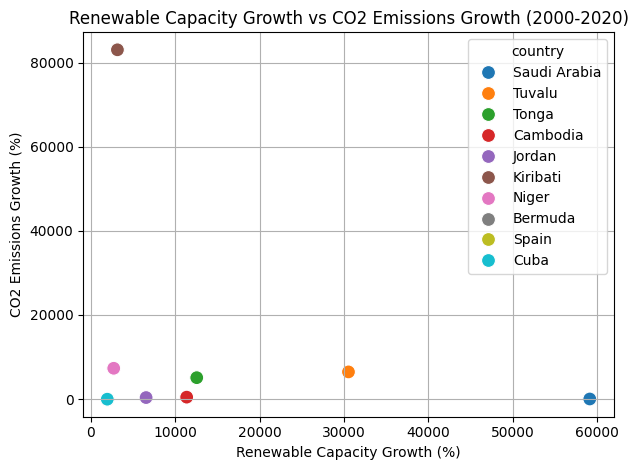

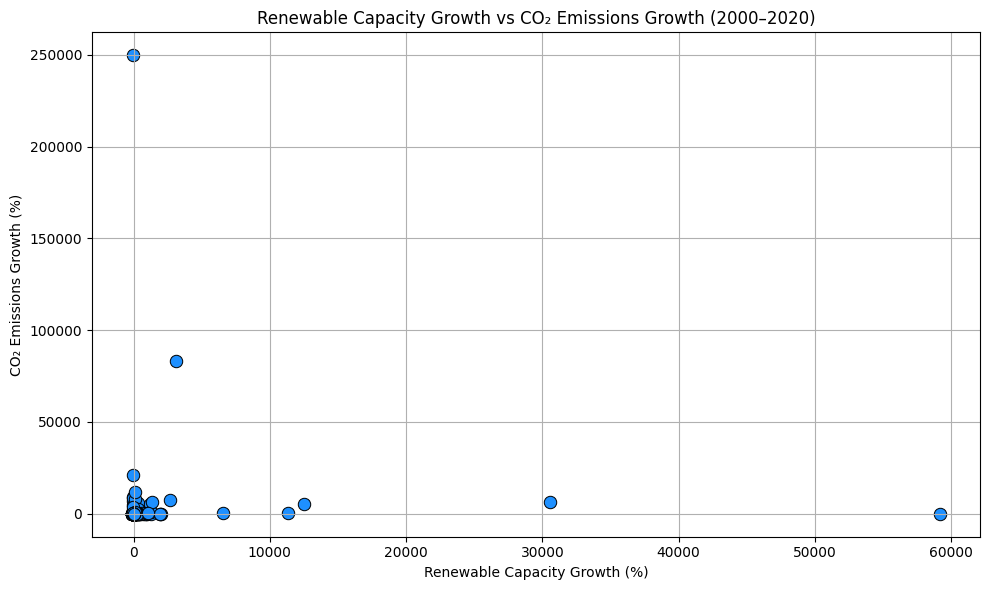

Correlation between renewable capacity growth and CO2 emissions growth: 0.00


In [ ]:
# select initial and final years
initial_year = 2000
final_year = 2020

# filter data for initial and final years
df_start = processed_df[processed_df['year'] == initial_year]
df_end = processed_df[processed_df['year'] == final_year]




# Merge the two DataFrames on 'country'
df_merged = pd.merge(df_start[['country', 'renewable_capacity_per_capita', 'co2_emissions_kt']],
                     df_end[['country', 'renewable_capacity_per_capita', 'co2_emissions_kt']],
                     on='country', suffixes=('_start', '_end')
)

# There is a problem with the data, some countries have 0 renewable capacity per capita in the initial year and 
# this causes division by zero in the growth calculation. We will filter these out.
df_merged = df_merged[df_merged['renewable_capacity_per_capita_start'] > 0]

# calculate growth percentage
df_merged['renewable_capacity_growth'] = (
    df_merged['renewable_capacity_per_capita_end'] - df_merged['renewable_capacity_per_capita_start']
) / df_merged['renewable_capacity_per_capita_start'] * 100

df_merged['co2_emissions_growth'] = (
    df_merged['co2_emissions_kt_end'] - df_merged['co2_emissions_kt_start']
) / df_merged['co2_emissions_kt_start'] * 100

# Calculate correlation between renewable capacity growth and CO2 emissions growth
correlation = df_merged[['renewable_capacity_growth', 'co2_emissions_growth']].corr().iloc[0, 1]
print(f"Correlation between renewable capacity growth and CO2 emissions growth: {correlation:.2f}")

# select top 10 countries with highest growth in renewable capacity
top10 = df_merged.sort_values("renewable_capacity_growth", ascending=False).head(10)
sns.scatterplot(
    data=top10,
    x='renewable_capacity_growth',
    y='co2_emissions_growth',
    hue='country',
    s=100,
    palette='tab10'
)
plt.title('Renewable Capacity Growth vs CO2 Emissions Growth (2000-2020)')
plt.xlabel('Renewable Capacity Growth (%)')
plt.ylabel('CO2 Emissions Growth (%)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Create a scatter plot for renewable capacity growth vs CO2 emissions growth
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_merged,
    x='renewable_capacity_growth',
    y='co2_emissions_growth',
    s=80,
    color='dodgerblue',
    edgecolor='black'
)
plt.title('Renewable Capacity Growth vs CO₂ Emissions Growth (2000–2020)')
plt.xlabel('Renewable Capacity Growth (%)')
plt.ylabel('CO₂ Emissions Growth (%)')
plt.grid(True)
plt.tight_layout()
plt.show()


# Calculate correlation between renewable capacity growth and CO2 emissions growth
correlation = df_merged[['renewable_capacity_growth', 'co2_emissions_growth']].corr().iloc[0, 1]
print(f"Correlation between renewable capacity growth and CO2 emissions growth: {correlation:.2f}")

### Hypothesis 4: Renewable Growth vs CO₂ Emissions Reduction

This hypothesis proposed that countries increasing their renewable electricity capacity per capita would also reduce their CO₂ emissions over time.

However, analysis of data from 2000 to 2020 shows **no meaningful correlation** between these two variables (r = 0.00). Many countries that expanded renewable infrastructure also increased emissions, likely due to:

- Parallel expansion of fossil fuel energy,
- Industrial growth outpacing decarbonization,
- Or use of renewables without displacing carbon-intensive sources.

Therefore, the hypothesis is **not supported** by the global data. A renewable energy transition alone does not guarantee reduced emissions — broader systemic changes are needed.


---

NOTE

* You may add as many sections as you want, as long as it supports your project workflow.
* All notebook's cells should be run top-down (you can't create a dynamic wherein a given point you need to go back to a previous cell to execute some task, like go back to a previous cell and refresh a variable content)

---

# Push files to Repo

* In cases where you don't need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.

In [ ]:
import os
try:
  # create your folder here
  # os.makedirs(name='')
except Exception as e:
  print(e)
